# Evaluation of EasyStock Learner

In [43]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import finnhub

## Question 1: How does the distribution of ratings for the LLM compare to the ratings by analyst

In [91]:
llm_ratings = pd.read_csv("../data/evaluation/rating_distributions/rating_dist_updated.csv")
llm_ratings

,Ticker,Rating With News,Rating Without News
0,UBER,Buy,Buy
1,SPGI,Buy,Buy
2,AXP,Hold,Hold
3,AAPL,Sell,Hold
4,MSFT,Hold,Hold
5,NVDA,Hold,Hold
6,AMD,Sell,Sell
7,CVS,Buy,Hold
8,AMZN,Hold,Hold
9,GOOGL,Hold,Hold


In [95]:
# Initialize Finnhub client (replace 'YOUR_API_KEY' with your actual key)
finnhub_client = finnhub.Client(api_key='ctkp081r01qn6d7j5lt0ctkp081r01qn6d7j5ltg')

# Load your CSV
df = llm_ratings

# Clean column names and values
df.columns = df.columns.str.strip()
df["Ticker"] = df["Ticker"].str.strip()
df["Rating With News"] = df["Rating With News"].str.strip()

# Define rating order and colors
rating_order = ["Strong Buy", "Buy", "Hold", "Sell", "Strong Sell"]
rating_colors_dict = {
    "Strong Buy": "#067E00",  # Dark Green
    "Buy": "#3BD133",         # Green
    "Hold": "#FBF909",        # Yellow
    "Sell": "#FBAA09",        # Orange
    "Strong Sell": "#FB1509"  # Red
}

# 1. Get LLM ratings with news
llm_counts = df["Rating With News"].value_counts().reindex(rating_order, fill_value=0)
llm_df = pd.DataFrame({
    "Rating Type": rating_order,
    "Count": llm_counts.values,
    "Source": "LLM With News"
})

# 2. Get Analyst ratings from Finnhub
tickers = df["Ticker"].unique()
analyst_agg = {r: 0 for r in rating_order}

for ticker in tickers:
    try:
        recs = finnhub_client.recommendation_trends(ticker)
        if recs:
            latest = recs[-1]
            analyst_agg["Strong Buy"] += latest.get("strongBuy", 0)
            analyst_agg["Buy"] += latest.get("buy", 0)
            analyst_agg["Hold"] += latest.get("hold", 0)
            analyst_agg["Sell"] += latest.get("sell", 0)
            analyst_agg["Strong Sell"] += latest.get("strongSell", 0)
    except Exception as e:
        print(f"Error fetching for {ticker}: {e}")

analyst_df = pd.DataFrame({
    "Rating Type": rating_order,
    "Count": [analyst_agg[r] for r in rating_order],
    "Source": "Analyst Ratings"
})

# 3. Combine data
combined_df = pd.concat([llm_df, analyst_df], ignore_index=True)

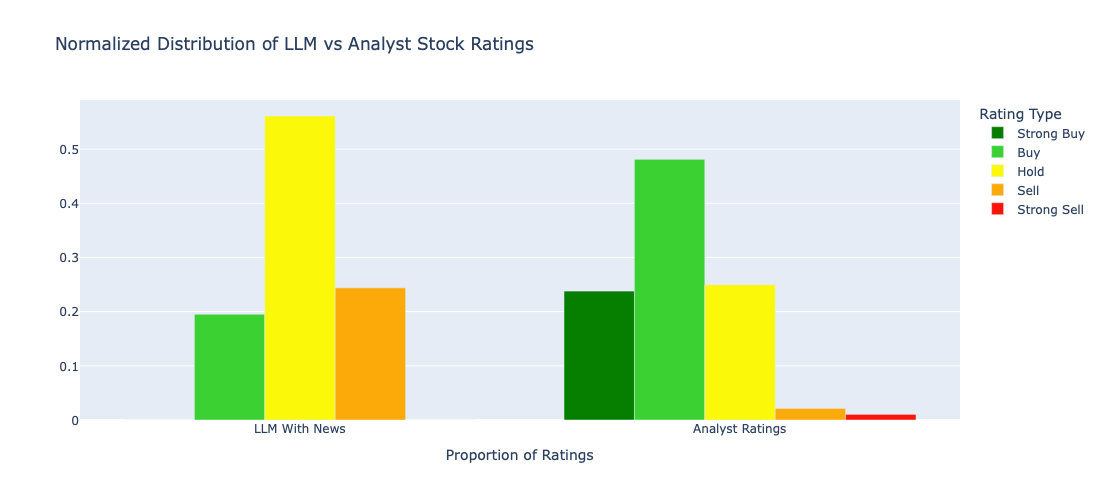

In [97]:
# Normalize the counts within each source group
normalized_df = combined_df.copy()
total_per_source = normalized_df.groupby("Source")["Count"].transform("sum")
normalized_df["Proportion"] = normalized_df["Count"] / total_per_source

# Plot using proportions
fig = px.bar(
    normalized_df,
    x="Source",
    y="Proportion",
    color="Rating Type",
    barmode="group",
    category_orders={"Rating Type": rating_order},
    color_discrete_map=rating_colors_dict,
    title="Normalized Distribution of LLM vs Analyst Stock Ratings",
    height=500
)

fig.update_layout(
    xaxis_title="Proportion of Ratings",
    yaxis_title="",
    legend_title="Rating Type",
    xaxis_tickformat=".0%"  # Format as percentage
)

fig.show()

The provided bar chart compares the normalized distribution of stock ratings generated by a Large Language Model (LLM) incorporating news data against those issued by human analysts. The LLM's ratings are heavily concentrated in the 'Hold' category, representing approximately 57% of its recommendations. 'Buy' ratings constitute the next largest proportion for the LLM, at around 20%, followed by 'Sell' at roughly 23%. The LLM issued very few 'Strong Buy' and 'Strong Sell' ratings.

In contrast, the distribution of analyst ratings skews significantly towards positive sentiment. 'Buy' ratings are the most frequent, making up approximately 48% of their assessments, followed by 'Hold' at around 25%. 'Strong Buy' ratings account for roughly 24% of analyst recommendations. 'Sell' ratings are considerably less common among analysts (around 2%), and 'Strong Sell' ratings are minimal (around 1%).

The LLM's pronounced inclination towards 'Hold' recommendations, constituting the majority of its assessments, alongside a significant proportion of 'Sell' ratings, suggests a more risk-averse analytical posture. This tendency implies that the AI model, despite being prompted for objectivity, may prioritize the identification and potential impact of negative signals or uncertainties present within the provided news and financial data. The comparatively lower incidence of 'Buy' and near absence of 'Strong Buy' ratings further underscores this cautious approach, indicating a higher threshold for the LLM to confidently recommend positive investment action based solely on the structured and unstructured information it processes.

Conversely, the rating distribution of human analysts reveals a distinct optimistic bias. The predominance of 'Buy' and 'Strong Buy' recommendations signifies a generally more favorable outlook on the assessed stocks. While 'Hold' ratings still constitute a notable segment, the significantly lower proportion of 'Sell' and 'Strong Sell' ratings suggests a greater willingness among human analysts to identify and emphasize positive investment drivers. This divergence likely reflects the nuanced and often qualitative nature of human financial analysis, which can incorporate broader macroeconomic perspectives, industry-specific knowledge, and forward-looking interpretations that may extend beyond the explicit content of the news and financial data accessible to the LLM. The objective programming of the LLM, while aiming for unbiased evaluation, appears to result in a more conservative interpretation, potentially prioritizing the avoidance of strong positive recommendations unless supported by unequivocally compelling evidence within its constrained information domain. This highlights a fundamental difference in how AI models and human experts synthesize information and form investment opinions.

## Question 2: Does the inclusion of news data affect the LLM rating?


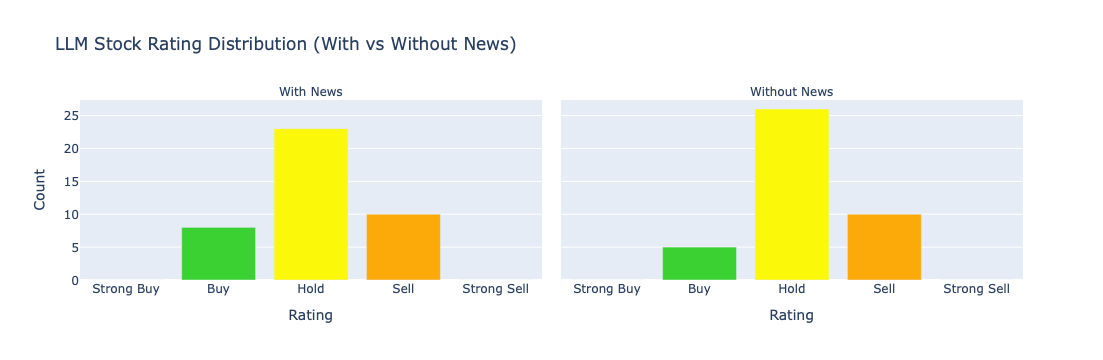

In [99]:
df = llm_ratings

df.columns = df.columns.str.strip()
df['Rating With News'] = df['Rating With News'].str.strip()
df['Rating Without News'] = df['Rating Without News'].str.strip()

rating_colors_dict = {
    "Strong Buy": "#067E00",   # Dark Green
    "Buy": "#3BD133",          # Green
    "Hold": "#FBF909",         # Yellow
    "Sell": "#FBAA09",         # Orange
    "Strong Sell": "#FB1509"   # Red
}
rating_order = ["Strong Buy", "Buy", "Hold", "Sell", "Strong Sell"]

df_long = df.melt(
    id_vars=["Ticker"],
    value_vars=["Rating With News", "Rating Without News"],
    var_name="news_type",
    value_name="rating"
)

df_long['news_type'] = df_long['news_type'].str.replace('Rating ', '')

rating_counts = df_long.groupby(['news_type', 'rating']).size().reset_index(name='count')

all_combos = pd.MultiIndex.from_product(
    [df_long["news_type"].unique(), rating_order],
    names=["news_type", "rating"]
).to_frame(index=False)

rating_counts = pd.merge(all_combos, rating_counts, on=["news_type", "rating"], how="left").fillna(0)

# Plot
fig = px.bar(
    rating_counts,
    x="rating",
    y="count",
    facet_col="news_type",
    category_orders={"rating": rating_order},
    color="rating",
    color_discrete_map=rating_colors_dict,
    labels={"rating": "Rating", "count": "Count"},
    title="LLM Stock Rating Distribution (With vs Without News)"
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(showlegend=False)
fig.show()

In [102]:
different_ratings_df = llm_ratings[llm_ratings['Rating With News'] != llm_ratings['Rating Without News']]
different_ratings_df

,Ticker,Rating With News,Rating Without News
3,AAPL,Sell,Hold
7,CVS,Buy,Hold
10,META,Hold,Buy
12,PM,Hold,Sell
13,COR,Hold,Sell
16,MA,Buy,Hold
20,ORCL,Hold,Sell
25,VST,Sell,Hold
26,COST,Buy,Hold
35,F,Sell,Hold


Across the dataset of 41 stock entries, the LLM's rating differed in 11 instances when news data was incorporated into its analysis. This observation suggests that the inclusion of news sentiment and information resulted in a change of assessment for approximately 26.8% of the evaluated stocks. While not a complete overhaul of its ratings, this proportion indicates that news data did exert a non-negligible influence on the LLM's stock rating decisions for a notable subset of the analyzed entries. Therefore, while the fundamental financial data likely formed the primary basis of the LLM's ratings, the integration of news sentiment and events did introduce a discernible degree of variability and ultimately impacted the final stock recommendation in over a quarter of the cases.

In [182]:
df = llm_ratings  

# Count ratings for both columns
count_with_news = df['Rating With News'].value_counts()
count_without_news = df['Rating Without News'].value_counts()

# Create a new DataFrame with the exact structure you want
rating_counts = pd.DataFrame({
    'Rating': ['Buy', 'Hold', 'Sell'],
    'With News': [
        count_with_news.get('Buy', 0),
        count_with_news.get('Hold', 0),
        count_with_news.get('Sell', 0)
    ],
    'Without News': [
        count_without_news.get('Buy', 0),
        count_without_news.get('Hold', 0),
        count_without_news.get('Sell', 0)
    ]
})

# Set Rating as the index to match your desired output format
rating_counts.set_index('Rating', inplace=True)

# Convert to integers (in case any counts were floats)
rating_counts = rating_counts.astype(int)

print(rating_counts)

        With News  Without News
Rating                         
Buy             8             5
Hold           23            26
Sell           10            10


In [188]:
import pandas as pd
from scipy.stats import chi2_contingency

# Load the data from CSV
df = llm_ratings

# Create a contingency table of paired ratings
contingency_table = pd.crosstab(
    df['Rating With News'],
    df['Rating Without News'],
    margins=False
)

# Ensure all rating categories are explicitly included
for rating in ['Buy', 'Hold', 'Sell']:
    if rating not in contingency_table.columns:
        contingency_table[rating] = 0
    if rating not in contingency_table.index:
        contingency_table.loc[rating] = 0

# Reorder rows/columns to standardize the table
contingency_table = contingency_table.reindex(
    index=['Buy', 'Hold', 'Sell'],
    columns=['Buy', 'Hold', 'Sell']
).fillna(0).astype(int)

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print results
print("Contingency Table (Ratings With News vs. Without News):")
print(contingency_table)
print(f"\nChi-square Statistic: {chi2:.2f}")
print(f"p-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

# Statistical interpretation
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: Reject H₀. News affects stock ratings (p < 0.05).")
else:
    print("\nConclusion: Fail to reject H₀. News has NO significant effect (p ≥ 0.05).")

Contingency Table (Ratings With News vs. Without News):
Rating Without News  Buy  Hold  Sell
Rating With News                    
Buy                    4     4     0
Hold                   1    19     3
Sell                   0     3     7

Chi-square Statistic: 26.77
p-value: 2.2075567914906614e-05
Degrees of Freedom: 4

Conclusion: Reject H₀. News affects stock ratings (p < 0.05).
